# This notebook processes ATL11 data into a format easy to compare with Alpine3D
## To Do:
1. Collect data from all three beams into xarray objects

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import glob

import pyproj
from pyproj import Geod
from pyproj import Proj, transform
from fiona.crs import from_epsg
from osgeo import osr

# Get spatial bounds of Alpine3D

In [2]:
ds = xr.open_dataset("../data/A3D-2015-2020-daily-snd.nc")

In [3]:
xmin = ds['easting'].min().values
xmax = ds['easting'].max().values
ymin = ds['northing'].min().values
ymax = ds['northing'].max().values

# Functions to get ATL11 into NetCDF

In [4]:
def read_ATL11(path):
    '''
    Read ATL11 H5 binary file into numpy arrays. 
    ATL11 spec: https://nsidc.org/sites/nsidc.org/files/technical-references/ICESat2_ATL11_ATBD_r004.pdf
    
    Example:
    
    ATL11_path = "/scratch/summit/erke2265/ATL11/data/ATL11_042310_0309_003_01.h5"
    data = read_ATL11(ATL11_path)
    
    # Note that its easy to replace pair1 (pt1) with pair2 (pt2) and pair3 (pt3)
    pair1_lat = data['pt1/latitude'][:]
    pair1_lon = data['pt1/longitude'][:]
    pair1_dt = data['pt1/delta_time'][:]
    pair1_h = data['pt1/h_corr'][:]
    pair1_h_sigma = data['pt1/h_corr_sigma'][:]
    pair1_h_sigma_systematic = data['pt1/h_corr_sigma_systematic'][:]
    '''
    
    # Load file into memory 
    data = h5py.File(path, 'r')
    
    return data

def ATL11_to_NetCDF(path):
    
    '''
    Convert ATL11 H5 binary file to Xarray data set. 
    
    To do: Collect data from all three pairs! 
    '''
    
    data = read_ATL11(path)
    
    da1_hcorr = xr.DataArray(data['pt1/h_corr'][:], coords={"lat": data['pt1/latitude'][:], "cycle": np.arange(data['pt1/h_corr'][:].shape[1]) + 1}, dims=("lat", "cycle"))
    da1_hcorr = da1_hcorr.assign_coords(lon=("lat", data['pt1/longitude'][:]))

    da1_hcorr_sigma = xr.DataArray(data['pt1/h_corr_sigma'][:], coords={"lat": data['pt1/latitude'][:], "cycle": np.arange(data['pt1/h_corr'][:].shape[1]) + 1}, dims=("lat", "cycle"))
    da1_hcorr_sigma = da1_hcorr_sigma.assign_coords(lon=("lat", data['pt1/longitude'][:]))

    da1_hcorr_sigma_systematic = xr.DataArray(data['pt1/h_corr_sigma'][:], coords={"lat": data['pt1/latitude'][:], "cycle": np.arange(data['pt1/h_corr'][:].shape[1]) + 1}, dims=("lat", "cycle"))
    da1_hcorr_sigma_systematic = da1_hcorr_sigma_systematic.assign_coords(lon=("lat", data['pt1/longitude'][:]))

    ds1 = xr.Dataset({"Height": da1_hcorr})
    ds1['Height_Sigma'] = da1_hcorr_sigma
    ds1['Height_Sigma_Sytematic'] = da1_hcorr_sigma_systematic
    
    return ds1

def qc_ATL11(path):
    
    ds1 = ATL11_to_NetCDF(path)
    ds1['Height'] = ds1['Height'].where(ds1['Height'] < 1e10, np.nan)
    ds1['Height'] = ds1['Height'].where(ds1['Height'] > 0, np.nan)
    
    return ds1
    
def spatial_sample_ATL11(path, xmin, xmax, ymin, ymax):
    
    '''
    Sets values outside spatial box to NaN
    
    1. Regrid lat/lon to x/y in epsg3031
    2. Set values outside of box to NaN 
    3. Assign x and y as coordinates
    
    '''
    
    # Load lat/lon
    ds1 = qc_ATL11(path)
    lat = ds1['lat'].values
    lon = ds1['lon'].values
    
    # Convert lat/lon to x/y in epsg3031
    # Source and target EPSG
    src = osr.SpatialReference()
    tgt = osr.SpatialReference()
    src.ImportFromEPSG(4326) # WGS-84
    tgt.ImportFromEPSG(3031) # South Polar Stereo

    # Define transformation
    transform = osr.CoordinateTransformation(src, tgt)

    # Initialize arrays
    x = np.zeros(len(lon)); x[:] = np.nan
    y = np.zeros(len(lat)); y[:] = np.nan

    # Perform transformation
    for j in range(0, len(x)):
        coords = transform.TransformPoint(lat[j], lon[j]) # Lat, Lon
        x[j], y[j] = coords[0:2]
        
    # Set values outside of box to NaN!    
    x[x < xmin] = np.nan
    x[x > xmax] = np.nan
    y[np.argwhere(np.isnan(x))] = np.nan    

    y[y < ymin] = np.nan
    y[y > ymax] = np.nan
    x[np.argwhere(np.isnan(y))] = np.nan  
    
    ds1['Height'][np.argwhere(np.isnan(x))[:,0],:] = np.nan
    ds1['Height_Sigma'][np.argwhere(np.isnan(x))[:,0],:] = np.nan
    ds1['Height_Sigma_Sytematic'][np.argwhere(np.isnan(x))[:,0],:] = np.nan
    
    # Change lat/lon to x/y
    ds1['lon'] = x
    ds1['lat'] = y
    ds1 = ds1.rename({'lat':'y', 'lon':'x'})

    return ds1

def save_NetCDF(path, xmin, xmax, ymin, ymax):
    
    ds = spatial_sample_ATL11(path, xmin, xmax, ymin, ymax)
    
    tgt_path = "../data/" + path.split("/")[-1][:-3] + ".nc"
    ds.to_netcdf(tgt_path, mode="w")
    print(tgt_path)
    
    return tgt_path

# Application on one file

In [5]:
# Perform file processing
src_path = "/scratch/summit/erke2265/ATL11/data/ATL11_042310_0309_003_01.h5"
tgt_path = save_NetCDF(src_path, xmin, xmax, ymin, ymax)

# Open processed file
ds_ATL11 = xr.open_dataset(tgt_path)

../data/ATL11_042310_0309_003_01.nc


In [6]:
ds_ATL11

<xarray.Dataset>
Dimensions:                 (cycle: 7, x: 13177, y: 13177)
Coordinates:
  * y                       (y) float64 nan nan nan nan nan ... nan nan nan nan
  * cycle                   (cycle) int64 1 2 3 4 5 6 7
  * x                       (x) float64 nan nan nan nan nan ... nan nan nan nan
Data variables:
    Height                  (y, cycle) float32 ...
    Height_Sigma            (y, cycle) float32 ...
    Height_Sigma_Sytematic  (y, cycle) float32 ...

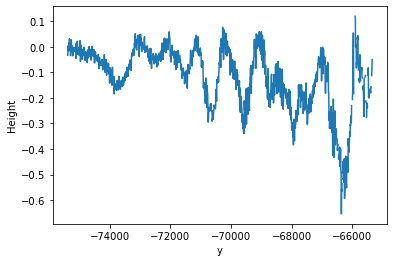

In [7]:
dh = ds_ATL11['Height'][:,4] - ds_ATL11['Height'][:,2]
dh.plot()

# Perform operation several (or all files)

In [8]:
src_dir = "/scratch/summit/erke2265/ATL11/data/*.h5"
src_files = glob.glob(src_dir)

n_max_files = 5 # Test
# n_max_files = len(src_files) # All files

for j in range(0, n_max_files):
    print(j)
    save_NetCDF(src_files[j], xmin, xmax, ymin, ymax)

0
../data/ATL11_087410_0309_003_01.nc
1
../data/ATL11_025911_0309_003_01.nc
2
../data/ATL11_106212_0309_003_01.nc
3
../data/ATL11_008011_0309_003_01.nc
4
../data/ATL11_091912_0309_003_01.nc
